# Esame di Probabilità e Statistica 18 Settembre 2025

##  Carlo Bruno Torreggiani

In questo notebook si è inizialmente studiato la distribuzione del numero dei comuni divisi per numero di abitanti e di come la popolazione totale si distribuisca in tali comuni. Successivamente, si è analizzato l'andamento del tasso di crescita dei comuni per numero di abitanti, con un focus su quelli con tasso negativo. 

In [59]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats 
import scipy
import seaborn as sns
import matplotlib.pylab as plt
from PIL import Image
import os
import re

In [60]:
# importo i dati ############################################################################à
inData_Residenti = pd.read_excel("Residenti.xlsx", header = 1)
inData_Iscritti = pd.read_excel("iscritti.xlsx", header = 1)
inData_Cancellati = pd.read_excel("Cancellati.xlsx", header = 1)


# Rimuovo spazi dai nomi delle colonne per coerenza
inData_Residenti.columns = inData_Residenti.columns.str.strip()
inData_Iscritti.columns = inData_Iscritti.columns.str.strip()
inData_Cancellati.columns = inData_Cancellati.columns.str.strip()


In [61]:
# tolgo l'ultima riga perché risulta vuota
inData_Cancellati = inData_Cancellati.drop(inData_Cancellati.index[-1])
inData_Residenti = inData_Residenti.drop(inData_Residenti.index[-1])
inData_Iscritti = inData_Iscritti.drop(inData_Iscritti.index[-1])

## Analisi qualitativa della popolazione contenuta nei comuni italiani

Voglio studiare qualitativamente l'andamento della popolazione nei vari comuni italiani. Per farlo, mi interesso di come varia il numero dei comuni per numero di abitanti, osservando anche come varia nel corso degli anni. Inoltre, mi sono chiesto se la popolazione è contenuta nella maggior parte in comuni grandi o piccoli, studiando il caso della popolazione del 2019.

#### Studio del numero di comuni divisi per numero di abitanti

In [62]:
# Creo una tabella che mi mostra i numeri di comuni divisi per numero di abitanti (2001) 

# Creo intervalli (bin) da 0 a 20000 con passo 1000
bins = list(range(0, 21000, 1000))

# Etichette per gli intervalli
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]

# Assegno a ogni comune l'intervallo di appartenenza
intervalli = pd.cut(inData_Residenti["2001"], bins=bins, labels=labels, right=False)

# Calcolo il numero di comuni per ogni intervallo senza somma cumulativa
conteggio_per_intervallo = intervalli.value_counts().sort_index()

# Creo la tabella finale
tabella = pd.DataFrame({'Intervallo popolazione': conteggio_per_intervallo.index,
                        'Numero comuni nel 2001': conteggio_per_intervallo.values})

print(tabella)

   Intervallo popolazione  Numero comuni nel 2001
0                   0-999                    1394
1               1000-1999                    1027
2               2000-2999                     632
3               3000-3999                     428
4               4000-4999                     343
5               5000-5999                     234
6               6000-6999                     179
7               7000-7999                     163
8               8000-8999                     116
9               9000-9999                      84
10            10000-10999                      80
11            11000-11999                      67
12            12000-12999                      54
13            13000-13999                      46
14            14000-14999                      36
15            15000-15999                      37
16            16000-16999                      27
17            17000-17999                      21
18            18000-18999                      19


In [63]:

inData_Residenti_filtrato = inData_Residenti[inData_Residenti['2001'] < 100000]
anni = [col for col in inData_Residenti_filtrato.columns if col != 'Territorio']

fig, ax = plt.subplots(figsize=(10,6))

# Impostazione limiti fissi prima dell'animazione
ax.set_xlim(0, 100000)
ax.set_ylim(0, 1600)
ax.grid(True)

def update(frame):
    ax.cla()  # pulisce la figura
    anno = anni[frame]
    data = pd.to_numeric(inData_Residenti_filtrato[anno], errors='coerce').dropna()
    ax.hist(data, bins=100, color='skyblue')
    ax.set_title(f'Distribuzione popolazione comuni - {anno}')
    ax.set_xlabel('Popolazione')
    ax.set_ylabel('Numero di comuni')
    # Riassegno limiti fissi e disabilito autoscale
    ax.set_xlim(0, 100000)
    ax.set_ylim(0, 1600)
    ax.autoscale(enable=False)
    ax.grid(True)

ani = animation.FuncAnimation(fig, update, frames=len(anni), repeat=True)
ani.save('popolazione_comuni.gif', writer='pillow', fps=1)
plt.close(fig)


![Popolazione Comuni](popolazione_comuni.gif)

Si può osservare che il numero di comuni con poche persone è nettamente maggiore di quelli con molte persone. Tale andamento non varia in modo considerevole nel corso degli anni. Sembra però che ci sia una piccola crescita nel numero di comuni con meno di 1.000 abitanti, mentre nelle fasce immediatamente successive sembra che ci sia una tendenza a diminuire. Potrebbe significare che i piccoli comuni tendono a svuotarsi e quindi a popolare maggiormente la fascia 0-1000?

#### Analisi qualitativa della distribuzione della popolazione nei comuni

In [64]:

# Crea cartella di output
cartella_output = os.path.join(os.getcwd(), 'popolazione_plots')
os.makedirs(cartella_output, exist_ok=True)

# Ottieni lista anni con dati numerici (ad esempio 2002, 2003, ..., 2019)
anni = [col for col in inData_Residenti.columns if str(col).isdigit()]

for anno in anni:
    residente_anno = inData_Residenti.loc[inData_Residenti['Territorio'] != 'Italia'].copy()
    residente_anno.loc[:, anno] = pd.to_numeric(residente_anno[anno], errors='coerce')
    
    bin_edges = list(range(0, int(residente_anno[anno].max()) + 10000, 5000))
    labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]
    residente_anno.loc[:, 'Fascia'] = pd.cut(residente_anno[anno], bins=bin_edges, labels=labels, right=False)
    
    summary = residente_anno.groupby('Fascia', observed=True)[anno].sum()
    total = residente_anno[anno].sum()
    percent = summary / total * 100
    
    tabella = pd.DataFrame({
        'Fascia abitanti': percent.index,
        'Percentuale popolazione': percent.values
    })
    
    filtered_tabella = tabella[tabella['Percentuale popolazione'] > 0].reset_index(drop=True)
    filtered_tabella['Percentuale cumulativa'] = filtered_tabella['Percentuale popolazione'].cumsum()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(filtered_tabella['Fascia abitanti'], filtered_tabella['Percentuale popolazione'], alpha=0.7, label='Percentuale popolazione')
    plt.plot(filtered_tabella['Fascia abitanti'], filtered_tabella['Percentuale cumulativa'], color='red', marker='o', label='Percentuale cumulativa')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Fascia abitanti')
    plt.ylabel('Percentuale (%)')
    plt.title(f'Distribuzione Percentuale della Popolazione per Fasce di Abitanti ({anno})')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    
    # Salva plot
    nome_file = os.path.join(cartella_output, f'popolazione_{anno}.png')
    plt.savefig(nome_file)
    plt.close()


In [70]:
from PIL import Image
import os

cartella_plot = os.path.join(os.getcwd(), 'popolazione_plots')
file_names = sorted([f for f in os.listdir(cartella_plot) if f.endswith('.png')])

# Carica immagini
frames = [Image.open(os.path.join(cartella_plot, f)) for f in file_names]

# Salva GIF
output_gif_path = os.path.join(os.getcwd(), 'popolazione.gif')
frames[0].save(
    output_gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=1000,  # durata frame in ms (1000 = 1 secondo)
    loop=0  # loop infinito
)

print(f"GIF salvata in: {output_gif_path}")


GIF salvata in: /home/fd11db33-da30-4cc8-8d8a-145b3b6cb4d9/Esame/popolazione.gif


![Distribuzione popolazione](popolazione.gif)


Si nota che la maggior parte della popolazione (50%) è contenuta nella parte di comuni che hanno meno di 20.000 abitanti. Un contributo considerevole è anche dato dalle poche grandi città. Effettivamente, il contributo percentuale del primo bin 0-5000 è in decrescita. Anche questa analisi sembra far intendere che i piccoli comuni in questo lasso di tempo si stanno depopolando, mentre i comuni più grandi diventino più popolosi.

## Andamento della decrescita dei piccoli comuni italiani 

In questa sezione viene analizzato il tasso di crescita dei piccoli comuni italiani, considerando quelli che hanno meno di 10.000 abitanti. 

#### Percentuale di comuni in decrescita

Si studia l'andamento qualitativo dei tassi di crescita dei comuni divisi per numero di abitanti. Si costruisce un istogramma impilato che mostra in verde la percentuale di comuni che hanno un tasso di crescita positivo e in verde quelli con tasso negativo.

In [71]:

# Escludo la riga 'Italia'
inData_Residenti_NoTot = inData_Residenti[inData_Residenti['Territorio'] != 'Italia'].copy()
inData_Iscritti_NoTot = inData_Iscritti[inData_Iscritti['Territorio'] != 'Italia'].copy()
inData_Cancellati_NoTot = inData_Cancellati[inData_Cancellati['Territorio'] != 'Italia'].copy()

# Ottengo la lista degli anni (colonne numeriche)
anni = [col for col in inData_Residenti_NoTot.columns if str(col).isdigit()]

# Converto le colonne degli anni in numerico, evitando warning con .loc
for df in [inData_Residenti_NoTot, inData_Iscritti_NoTot, inData_Cancellati_NoTot]:
    for anno in anni:
        df.loc[:, anno] = pd.to_numeric(df[anno], errors='coerce')

# Calcolo saldo migratorio netto (iscritti - cancellati)
saldo = inData_Iscritti_NoTot.set_index('Territorio')[anni] - inData_Cancellati_NoTot.set_index('Territorio')[anni]

# Popolazione residente anno precedente (shiftata)
popolazione = inData_Residenti_NoTot.set_index('Territorio')[anni]
popolazione_shifted = popolazione.shift(axis=1)

# Sostituisco 0 con NaN nel denominatore per evitare divisione per zero
denominator = popolazione_shifted.values
denominator_safe = np.where(denominator == 0, np.nan, denominator)

# Calcolo tasso crescita netto percentuale evitando errori di divisione
with np.errstate(divide='ignore', invalid='ignore'):
    tasso_crescita_netto = saldo.values / denominator_safe
    tasso_crescita_netto = tasso_crescita_netto * 100

tasso_crescita_netto = pd.DataFrame(tasso_crescita_netto, index=saldo.index, columns=saldo.columns)





In [72]:

cartella_output = os.path.join(os.getcwd(), 'gif')
os.makedirs(cartella_output, exist_ok=True)

# Lista anni escludendo 2001 e 2019
anni = [col for col in inData_Residenti_NoTot.columns if str(col).isdigit() and col not in ['2019', '2001']]

# Calcolo il limite massimo y per uniformare gli assi
max_y = 0
for anno_riferimento in anni:
    popolazione_anno = inData_Residenti_NoTot.set_index('Territorio')[anno_riferimento].astype(float)
    tasso_crescita_anno = tasso_crescita_netto[anno_riferimento]
    df = pd.DataFrame({
        'popolazione': popolazione_anno,
        'tasso_crescita': tasso_crescita_anno
    })
    # Filtra comuni con popolazione < 10000
    df_small = df[df['popolazione'] < 10000].copy()
    bins = np.arange(0, 10000 + 1000, 1000)
    df_small['pop_bin'] = pd.cut(df_small['popolazione'], bins=bins, right=False)
    df_small['crescita_cat'] = np.where(df_small['tasso_crescita'] >= 0, 'Positivo', 'Negativo')
    count_df = df_small.groupby(['pop_bin', 'crescita_cat'], observed=True).size().unstack(fill_value=0)
    max_y = max(max_y, count_df.values.max())

for anno_riferimento in anni:
    popolazione_anno = inData_Residenti_NoTot.set_index('Territorio')[anno_riferimento].astype(float)
    tasso_crescita_anno = tasso_crescita_netto[anno_riferimento]
    df = pd.DataFrame({
        'popolazione': popolazione_anno,
        'tasso_crescita': tasso_crescita_anno
    })
    # Filtra comuni con popolazione < 10000
    df_small = df[df['popolazione'] < 10000].copy()
    bins = np.arange(0, 10000 + 1000, 1000)
    labels = [f'{int(bins[i])}-{int(bins[i+1])-1}' for i in range(len(bins)-1)]
    df_small['pop_bin'] = pd.cut(df_small['popolazione'], bins=bins, labels=labels, right=False)
    df_small['crescita_cat'] = np.where(df_small['tasso_crescita'] >= 0, 'Positivo', 'Negativo')
    count_df = df_small.groupby(['pop_bin', 'crescita_cat'], observed=True).size().unstack(fill_value=0)

    ax = count_df.plot(kind='bar', stacked=True, figsize=(14,7), color=['crimson', 'seagreen'])
    ax.set_xlabel('Fasce di popolazione comunale (abitanti)')
    ax.set_ylabel('Numero di comuni')
    ax.set_title(f'Tasso di crescita positivo/negativo per fasce popolazione\n(Comuni < 10.000 abitanti - Anno {anno_riferimento})')

    # Imposta etichette asse X con margini per evitare taglio
    ax.set_xticks(range(len(count_df.index)))
    ax.set_xticklabels(count_df.index, rotation=45, ha='right')
    ax.margins(x=0.01)

    plt.legend(title='Tasso di crescita')
    plt.grid(axis='y')
    ax.set_ylim(0, max_y * 1.9)  # margine y sopra massimo
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.30, right=0.98, left=0.07, top=0.93)

    nome_file = f'{cartella_output}/istogramma_{anno_riferimento}.png'
    plt.savefig(nome_file)
    plt.close()



In [73]:
# Costruisco la GIF

# Cartella 'gif' dentro la cartella di lavoro corrente
cartella = os.path.join(os.getcwd(), 'gif')

file_list = os.listdir(cartella)

def estrai_anno(nome_file):
    match = re.search(r'(\d{4})', nome_file)
    return int(match.group(1)) if match else 0

file_list_png = sorted(
    [f for f in file_list if f.endswith('.png') and '2019' not in f],
    key=estrai_anno
)

frames = [Image.open(os.path.join(cartella, fname)) for fname in file_list_png]

# Salva la GIF nella cartella di lavoro corrente (non dentro gif)
output_gif = os.path.join(os.getcwd(), 'istogrammi_animati.gif')

frames[0].save(
    output_gif,
    save_all=True,
    append_images=frames[1:],
    duration=1000,   # durata per frame in millisecondi
    loop=0
)



![Animazione istogrammi](istogrammi_animati.gif)


Sembra che per le fasce più basse ci sia un aumento del numero di comuni con tasso negativo. Si procede con un fit lineare per capire quantitativamente di quanto aumenta il numero di tali comuni. 

#### Fit lineare dei comuni in decrescita

Si vuole verificare che l'andamento del numero di comuni in decrescita vari linearmente negli anni. Per farlo, si procede con un fit lineare.

In [25]:

# Definisci fasce di popolazione da 0 a 10000 con step 1000
bins = np.arange(0, 10000 + 1000, 1000)
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]

# DataFrame per i risultati (anni come indice, fasce come colonne)
decrescita_time = pd.DataFrame(index=anni, columns=labels)

for anno in anni:
    popolazione_anno = inData_Residenti_NoTot.set_index('Territorio')[anno].astype(float)
    tasso_crescita_anno = tasso_crescita_netto[anno]
    df = pd.DataFrame({
        'popolazione': popolazione_anno,
        'tasso_crescita': tasso_crescita_anno
    })
    # Filtra comuni con popolazione < 10000
    df_small = df[df['popolazione'] < 10000].copy()
    # Assegna fascia di popolazione
    df_small['pop_bin'] = pd.cut(df_small['popolazione'], bins=bins, labels=labels, right=False)
    # Seleziona solo comuni in decrescita (tasso di crescita < 0)
    df_decrescita = df_small[df_small['tasso_crescita'] < 0]
    # Conta i comuni per fascia
    counts = df_decrescita.groupby('pop_bin', observed=True).size()
    # Riempie i NaN con 0 e assegna al DataFrame risultati
    decrescita_time.loc[anno] = counts.reindex(labels, fill_value=0)

# Converte valori a interi
decrescita_time = decrescita_time.astype(int)




Parametri del fit lineare per ciascuna fascia (coeff. angolare, intercetta):
0-999: coeff. angolare = 8.436, intercetta = -16295.853
1000-1999: coeff. angolare = 9.002, intercetta = -17622.162
2000-2999: coeff. angolare = 6.909, intercetta = -13592.368
3000-3999: coeff. angolare = 4.733, intercetta = -9316.603
4000-4999: coeff. angolare = 3.674, intercetta = -7243.132
5000-5999: coeff. angolare = 2.919, intercetta = -5772.250
6000-6999: coeff. angolare = 2.054, intercetta = -4051.382
7000-7999: coeff. angolare = 1.142, intercetta = -2235.147
8000-8999: coeff. angolare = 1.395, intercetta = -2756.338
9000-9999: coeff. angolare = 1.733, intercetta = -3447.015


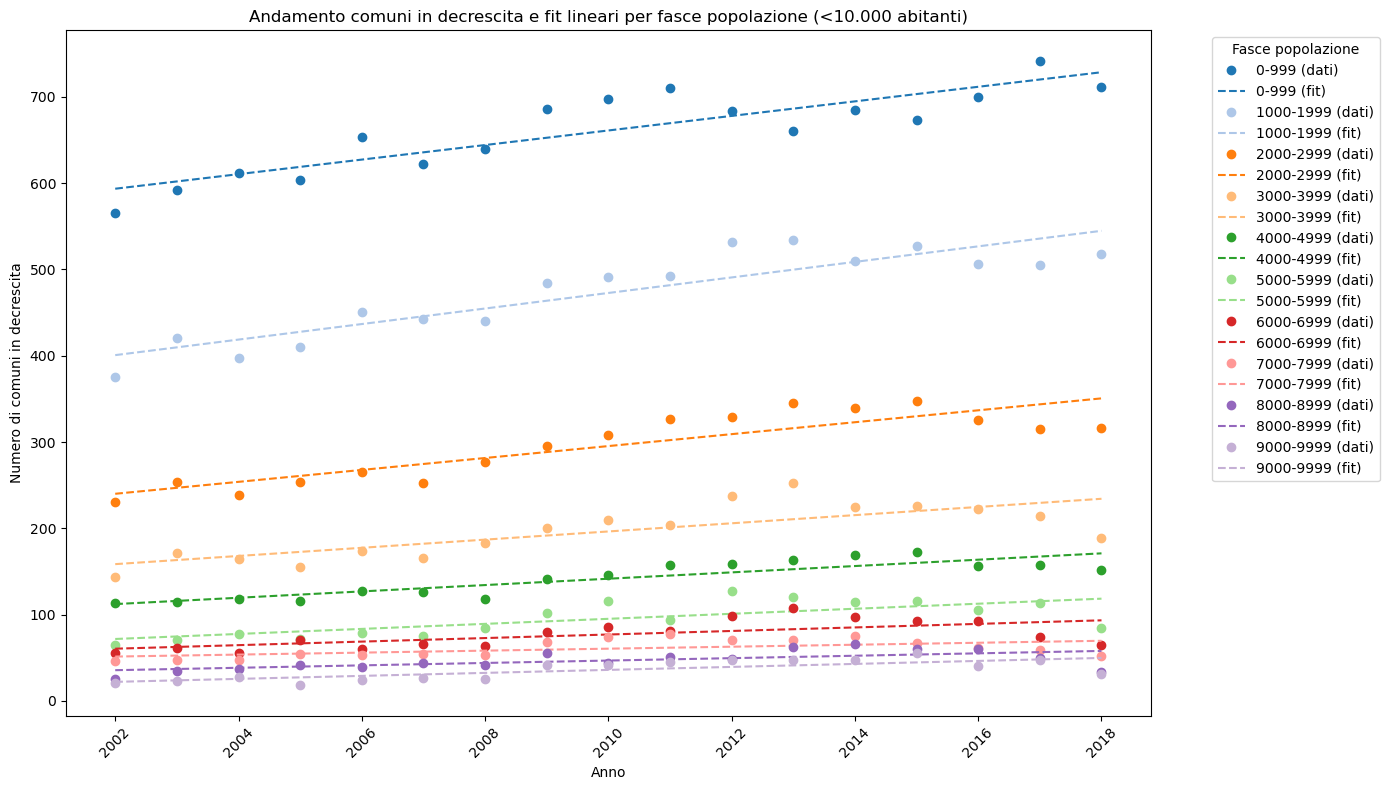

In [26]:
# Visualizzazione con fit lineare per ciascuna fascia di popolazione
plt.figure(figsize=(14, 8))
x = decrescita_time.index.astype(int).values
colors = plt.cm.tab20.colors  # palette di colori distinti

print("Parametri del fit lineare per ciascuna fascia (coeff. angolare, intercetta):")
for i, fascia in enumerate(labels):
    y = decrescita_time[fascia].values
    color = colors[i % len(colors)]
    # Fit lineare
    coeffs = np.polyfit(x, y, deg=1)
    p = np.poly1d(coeffs)
    y_fit = p(x)
    # Stampa parametri del fit
    slope, intercept = coeffs
    print(f"{fascia}: coeff. angolare = {slope:.3f}, intercetta = {intercept:.3f}")
    
    # Plot punti dati
    plt.plot(x, y, marker='o', linestyle='none', color=color, label=f'{fascia} (dati)')
    # Plot linea di fit lineare tratteggiata
    plt.plot(x, y_fit, linestyle='--', color=color, label=f'{fascia} (fit)')

plt.xticks(rotation=45)
plt.xlabel('Anno')
plt.ylabel('Numero di comuni in decrescita')
plt.title('Andamento comuni in decrescita e fit lineari per fasce popolazione (<10.000 abitanti)')
plt.legend(title='Fasce popolazione', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [56]:
import numpy as np

print("Coefficienti regressione (pendenza, intercetta) per fascia:")

for fascia in labels:
    y = decrescita_percentuale[fascia].values.astype(float)
    x = decrescita_percentuale.index.astype(int).values
    
    # Calcolo retta di regressione lineare
    coeffs = np.polyfit(x, y, deg=1)
    
    slope, intercept = coeffs
    print(f"{fascia}: coefficiente angolare = {slope:.4f}, intercetta = {intercept:.4f}")

Coefficienti regressione (pendenza, intercetta) per fascia:
0-999: coefficiente angolare = 0.6035, intercetta = -1165.6547
1000-1999: coefficiente angolare = 0.8791, intercetta = -1720.9142
2000-2999: coefficiente angolare = 1.0967, intercetta = -2157.5187
3000-3999: coefficiente angolare = 1.1032, intercetta = -2171.7023
4000-4999: coefficiente angolare = 1.0774, intercetta = -2124.0857
5000-5999: coefficiente angolare = 1.2475, intercetta = -2466.7735
6000-6999: coefficiente angolare = 1.1285, intercetta = -2226.0343
7000-7999: coefficiente angolare = 0.7050, intercetta = -1379.7204
8000-8999: coefficiente angolare = 1.2022, intercetta = -2376.1537
9000-9999: coefficiente angolare = 2.0629, intercetta = -4103.5889


Dal grafico si vede esplicitamente che il numero di comuni con tasso di crescita negativo aumenta nel corso degli anni. Per i bin associati alle fasce 0-1.000 e 1.000-2.000 tale crescita è molto più rapida di quella delle fasce successive, come avevamo ipotizzato precedentemente. Inoltre tale crescita è visibile anche nel fit dei valori percentuali, che significa che l'aumento del numero di tali comuni non è dovuto solo all'aumento del numero assoluto dentro ai bin ma è indice di una inversione nel trend di crescita di alcuni comuni all'interno degli stessi bin.